<a href="https://colab.research.google.com/github/Vikash-exe/Custom_segformers/blob/main/CustomB2_AGU_Convo2D_D_aug_LISS4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# If needed, uncomment to install deps
# !pip install -q transformers timm tifffile

import os
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import tifffile as tiff
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import SegformerForSemanticSegmentation

# Colab: mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [28]:
import zipfile
import os

# Path to your zip file
zip_path = "/content/drive/MyDrive/Dataset/Dataset.zip"
extract_dir = "/content/Dataset"   # where you want to unzip

# Make sure output dir exists
os.makedirs(extract_dir, exist_ok=True)

# Extract zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Dataset extracted to: {extract_dir}")

# Paths after extraction
images_path = os.path.join(extract_dir, "Dataset", "Images")
masks_path  = os.path.join(extract_dir, "Dataset", "Mask")

# Quick check
print("\nSample files:")
print("Images:", os.listdir(images_path)[:5])
print("Masks:", os.listdir(masks_path)[:5])


✅ Dataset extracted to: /content/Dataset

Sample files:
Images: ['Image_136.tif', 'Image_050.tif', 'Image_048.tif', 'Image_166.tif', 'Image_149.tif']
Masks: ['Mask_107.tif', 'Mask_131.tif', 'Mask_171.tif', 'Mask_222.tif', 'Mask_059.tif']


In [44]:
# ================================
# Dataset Definition (with Albumentations support)
# ================================
import os, numpy as np, torch
from torch.utils.data import Dataset
from PIL import Image
import tifffile as tiff

class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, image_size=512, num_classes=4, normalize=True, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_size = image_size
        self.num_classes = num_classes
        self.normalize = normalize
        self.transform = transform   # 🔥 Albumentations pipeline (if provided)

        # File lists
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.lower().endswith(('.tif','.tiff','.png','.jpg','.jpeg'))])
        self.mask_files  = sorted([f for f in os.listdir(masks_dir)  if f.lower().endswith(('.tif','.tiff','.png','.jpg','.jpeg'))])

        assert len(self.image_files) == len(self.mask_files), "❌ Images and masks count mismatch!"

        # Normalization stats (ImageNet)
        self.mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
        self.std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

    def _read_image(self, path):
        if path.lower().endswith(('.tif','.tiff')):
            arr = tiff.imread(path)
        else:
            arr = np.array(Image.open(path))

        arr = np.squeeze(arr)
        if arr.dtype != np.uint8:
            arr = (255 * (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)).astype(np.uint8)
        if arr.ndim == 2:
            arr = np.stack([arr]*3, axis=-1)  # grayscale → RGB
        return arr

    def _read_mask(self, path):
        if path.lower().endswith(('.tif','.tiff')):
            arr = tiff.imread(path)
        else:
            arr = np.array(Image.open(path))
        arr = np.squeeze(arr)
        if arr.ndim == 3:
            arr = arr[:, :, 0]  # take first channel if 3D
        return arr

    def __getitem__(self, idx):
        img_path  = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir,  self.mask_files[idx])

        img = self._read_image(img_path)
        mask = self._read_mask(mask_path)

        # 🔥 Apply Albumentations if provided
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented["image"], augmented["mask"]
        else:
            # Default resizing
            img = Image.fromarray(img).resize((self.image_size, self.image_size), resample=Image.BILINEAR)
            mask = Image.fromarray(mask).resize((self.image_size, self.image_size), resample=Image.NEAREST)

            img = np.array(img, dtype=np.float32) / 255.0
            mask = np.array(mask, dtype=np.int64)

            # Normalize
            if self.normalize:
                img = (img - self.mean) / self.std

            # To tensor
            img = np.transpose(img, (2, 0, 1))  # C,H,W
            img = torch.tensor(img, dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.long)

        # Ensure mask class indices are valid
        mask[mask >= self.num_classes] = self.num_classes - 1

        return img, mask

    def __len__(self):
        return len(self.image_files)


# ================================
# Step 1: Quick Dataset Check
# ================================
IMAGES_DIR = "/content/Dataset/Dataset/Images"
MASKS_DIR  = "/content/Dataset/Dataset/Mask"

full_dataset = SegmentationDataset(IMAGES_DIR, MASKS_DIR, image_size=512, num_classes=4, normalize=True)

print("✅ Dataset loaded!")
print("Total samples:", len(full_dataset))

x, y = full_dataset[0]
print("Image shape:", x.shape)   # expect [3,512,512]
print("Mask shape:", y.shape)    # expect [512,512]


✅ Dataset loaded!
Total samples: 232
Image shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([512, 512])


In [45]:
# ================================
# Step 2: Train/Val Split + Loader
# ================================
from torch.utils.data import random_split, DataLoader

train_size = int(0.8 * len(full_dataset))
val_size   = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

BATCH_SIZE = 4
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

xb, yb = next(iter(train_loader))
print("Batch shapes -> images:", tuple(xb.shape), "masks:", tuple(yb.shape))  # [B,3,512,512], [B,512,512]


Train samples: 185, Val samples: 47
Batch shapes -> images: (4, 3, 512, 512) masks: (4, 512, 512)


cheching the sequence

In [46]:
IMAGES_DIR = "/content/Dataset/Dataset/Images"
MASKS_DIR  = "/content/Dataset/Dataset/Mask"

dataset = LULCDataset(IMAGES_DIR, MASKS_DIR, processor)

print(f"✅ Dataset loaded with {len(dataset)} pairs")

# Show first 5 pairs to confirm correct matching
for i in range(5):
    img_file, mask_file = dataset.pairs[i]
    print(f"Pair {i}: {img_file}  <->  {mask_file}")


✅ Dataset loaded with 232 pairs
Pair 0: Image_001.tif  <->  Mask_001.tif
Pair 1: Image_002.tif  <->  Mask_002.tif
Pair 2: Image_003.tif  <->  Mask_003.tif
Pair 3: Image_004.tif  <->  Mask_004.tif
Pair 4: Image_005.tif  <->  Mask_005.tif


In [47]:
pip install albumentations


In [48]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=25,
                       border_mode=0, interpolation=1, p=0.7),  # interpolation=1 = NEAREST
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.3),
    A.ElasticTransform(p=0.2),
])


In [49]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, image_size=512, num_classes=4, normalize=True, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.lower().endswith(('.tif','.tiff','.png','.jpg','.jpeg'))])
        self.mask_files  = sorted([f for f in os.listdir(masks_dir)  if f.lower().endswith(('.tif','.tiff','.png','.jpg','.jpeg'))])
        assert len(self.image_files) == len(self.mask_files), f"Images({len(self.image_files)}) != Masks({len(self.mask_files)})"

        self.image_size = image_size
        self.num_classes = num_classes
        self.normalize = normalize
        self.transform = transform

        # ImageNet normalization
        self.mean = np.array([0.485, 0.456, 0.406], dtype=np.float32).reshape(3,1,1)
        self.std  = np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape(3,1,1)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path  = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir,  self.mask_files[idx])

        try:
            # ---- Image ----
            img = np.array(Image.open(img_path).convert("RGB"))
            mask = np.array(Image.open(mask_path))

            # Resize
            img = np.array(Image.fromarray(img).resize((self.image_size, self.image_size), resample=Image.BILINEAR))
            mask = np.array(Image.fromarray(mask).resize((self.image_size, self.image_size), resample=Image.NEAREST))

            #  Apply augmentation
            if self.transform is not None:
                augmented = self.transform(image=img, mask=mask)
                img, mask = augmented["image"], augmented["mask"]
            else:
                img = np.transpose(img, (2,0,1)).astype(np.float32) / 255.0
                if self.normalize:
                    img = (img - self.mean) / self.std
                img = torch.tensor(img, dtype=torch.float32)

            # Ensure mask class IDs
            mask = torch.tensor(mask, dtype=torch.long)
            mask[mask >= self.num_classes] = self.num_classes - 1

            return img, mask
        except Exception as e:
            print(f"Warning: Skipping image {img_path} due to error: {e}")
            return self.__getitem__((idx + 1) % len(self)) # Recursively call for next image

In [50]:
import torch
import torch.nn as nn

class AttentionUpsample(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()

        # --- Learnable upsampling instead of bilinear ---
        self.up = nn.ConvTranspose2d(
            in_channels, in_channels, kernel_size=2, stride=2
        )

        # Project input and skip connections to same channels
        self.conv_in = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv_skip = nn.Conv2d(skip_channels, out_channels, kernel_size=1)

        # Attention map
        self.attn = nn.Sequential(
            nn.Conv2d(out_channels * 2, out_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, 1, kernel_size=1),
            nn.Sigmoid()
        )

        # Final refinement
        self.conv_out = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x, skip):
        # 1. Upsample using ConvTranspose2d
        x = self.up(x)

        # 2. If size mismatch (odd dims), force match
        if x.shape[-2:] != skip.shape[-2:]:
            x = nn.functional.interpolate(x, size=skip.shape[2:], mode="nearest")

        # 3. Project features
        x_proj = self.conv_in(x)
        skip_proj = self.conv_skip(skip)

        # 4. Compute attention mask
        attn_map = self.attn(torch.cat([x_proj, skip_proj], dim=1))

        # 5. Weighted fusion
        out = attn_map * x_proj + (1 - attn_map) * skip_proj
        out = self.conv_out(out)
        return out


In [51]:
import torch
import torch.nn as nn
from transformers import SegformerModel

class CustomSegFormer(nn.Module):
    def __init__(self, num_classes=4, id2label=None, label2id=None):
        super(CustomSegFormer, self).__init__()

        # === Encoder (pretrained SegFormer B2) ===
        self.encoder = SegformerModel.from_pretrained(
            "nvidia/segformer-b2-finetuned-ade-512-512",
            output_hidden_states=True
        )

        # SegFormer B2 hidden sizes
        embed_dim = [64, 128, 320, 512]
        decoder_dim = 256

        # Projections
        self.linear_c4 = nn.Conv2d(embed_dim[3], decoder_dim, kernel_size=1)
        self.linear_c3 = nn.Conv2d(embed_dim[2], decoder_dim, kernel_size=1)
        self.linear_c2 = nn.Conv2d(embed_dim[1], decoder_dim, kernel_size=1)
        self.linear_c1 = nn.Conv2d(embed_dim[0], decoder_dim, kernel_size=1)

        # Attention-guided upsampling blocks
        self.agu3 = AttentionUpsample(decoder_dim, decoder_dim, decoder_dim)
        self.agu2 = AttentionUpsample(decoder_dim, decoder_dim, decoder_dim)
        self.agu1 = AttentionUpsample(decoder_dim, decoder_dim, decoder_dim)

        # Final classifier
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Conv2d(decoder_dim, num_classes, kernel_size=1)

    def forward(self, pixel_values):
        # === Encoder ===
        outputs = self.encoder(pixel_values)
        c1, c2, c3, c4 = outputs.hidden_states  # already (B, C, H, W)

        # Project to same decoder_dim
        c1, c2, c3, c4 = self.linear_c1(c1), self.linear_c2(c2), self.linear_c3(c3), self.linear_c4(c4)

        # === Decoder with AGU ===
        x = self.agu3(c4, c3)  # fuse high-level with C3
        x = self.agu2(x, c2)   # fuse with C2
        x = self.agu1(x, c1)   # fuse with C1

        # Final head
        x = self.dropout(x)
        logits = self.classifier(x)

        # Restore to original image size
        logits = nn.functional.interpolate(logits, size=pixel_values.shape[2:], mode="bilinear", align_corners=False)

        return logits


In [52]:
# === Usage ===
id2label = {0: "Urban", 1: "Water", 2: "Vegetation", 3: "Others"}
label2id = {v: k for k, v in id2label.items()}

model = CustomSegFormer(num_classes=4, id2label=id2label, label2id=label2id)
print(model)

CustomSegFormer(
  (encoder): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
      )


In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# id2label = {0:"Urban", 1:"Water", 2:"Vegetation", 3:"Others"}
# label2id = {v:k for k,v in id2label.items()}

# model = SegformerForSemanticSegmentation.from_pretrained(
#     "nvidia/segformer-b0-finetuned-ade-512-512",
#     num_labels=4,
#     id2label=id2label,
#     label2id=label2id,
#     ignore_mismatched_sizes=True,  # new head (4 classes) initialized
# )
model.to(device)

# Optim & training settings
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
num_epochs = 40


In [55]:
def pixel_accuracy(preds, labels):
    # preds: [B,H,W] (class ids), labels: [B,H,W]
    correct = (preds == labels).sum().item()
    total = labels.numel()
    return correct / total

def mean_iou(preds, labels, num_classes=4):
    # preds, labels: [B,H,W]
    ious = []
    for cls in range(num_classes):
        pred_c = (preds == cls)
        label_c = (labels == cls)
        inter = (pred_c & label_c).sum().item()
        union = (pred_c | label_c).sum().item()
        if union == 0:
            ious.append(float("nan"))  # ignore if class not present in both
        else:
            ious.append(inter / union)
    return np.nanmean(ious)


In [56]:
print(f"Train samples: {len(train_dataset)} ({len(train_loader)} batches of size {BATCH_SIZE})")
print(f"Val samples:   {len(val_dataset)} ({len(val_loader)} batches of size {BATCH_SIZE})")


Train samples: 185 (47 batches of size 4)
Val samples:   47 (12 batches of size 4)


In [57]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []
train_ious, val_ious = [], []

# Define the loss function
criterion = nn.CrossEntropyLoss()

for epoch in range(1, num_epochs+1):
    # ---- Train ----
    model.train()
    tr_loss, tr_acc, tr_iou = 0.0, 0.0, 0.0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} - Training"):
        imgs, masks = imgs.to(device), masks.to(device)

        # out = model(pixel_values=imgs, labels=masks)   # CrossEntropy inside
        # loss = out.loss
        # logits = out.logits                            # [B, num_classes, H, W]

        logits = model(pixel_values=imgs)             # [B, num_classes, H, W]
        loss = criterion(logits, masks)               # Calculate loss manually

        preds = torch.argmax(logits, dim=1)            # [B,H,W]

        # Resize predictions to match mask size for metric calculation
        preds_resized = torch.nn.functional.interpolate(preds.unsqueeze(1).float(),
                                                        size=masks.shape[-2:],
                                                        mode='nearest').squeeze(1).long()


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss += loss.item()
        tr_acc  += pixel_accuracy(preds_resized, masks)
        tr_iou  += mean_iou(preds_resized, masks, num_classes=4)

    tr_loss /= len(train_loader)
    tr_acc  /= len(train_loader)
    tr_iou  /= len(train_loader)

    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    train_ious.append(tr_iou)

    # ---- Validate ----
    model.eval()
    va_loss, va_acc, va_iou = 0.0, 0.0, 0.0
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc="Validating"):
            imgs, masks = imgs.to(device), masks.to(device)
            # out = model(pixel_values=imgs, labels=masks)
            # va_loss += out.loss.item()
            logits = model(pixel_values=imgs)
            va_loss += criterion(logits, masks).item()


            # logits = out.logits  # Remove this line
            preds = torch.argmax(logits, dim=1)
            # Resize predictions to match mask size for metric calculation
            preds_resized = torch.nn.functional.interpolate(preds.unsqueeze(1).float(),
                                                            size=masks.shape[-2:],
                                                            mode='nearest').squeeze(1).long()


            va_acc += pixel_accuracy(preds_resized, masks)
            va_iou += mean_iou(preds_resized, masks, num_classes=4)

    va_loss /= len(val_loader)
    va_acc  /= len(val_loader)
    va_iou  /= len(val_loader)

    val_losses.append(va_loss)
    val_accs.append(va_acc)
    val_ious.append(va_iou)

    print(f"Epoch {epoch}/{num_epochs} | "
          f"Train Loss: {tr_loss:.4f}  Val Loss: {va_loss:.4f}  |  "
          f"Train Acc: {tr_acc*100:.2f}%  Val Acc: {va_acc*100:.2f}%  |  "
          f"Train mIoU: {tr_iou:.4f}  Val mIoU: {va_iou:.4f}")

Validating: 100%|██████████| 12/12 [00:02<00:00,  4.25it/s]


Epoch 1/40 | Train Loss: 0.8950  Val Loss: 0.6147  |  Train Acc: 60.22%  Val Acc: 71.31%  |  Train mIoU: 0.2374  Val mIoU: 0.3689


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.29it/s]


Epoch 2/40 | Train Loss: 0.6064  Val Loss: 0.5729  |  Train Acc: 70.89%  Val Acc: 73.22%  |  Train mIoU: 0.3969  Val mIoU: 0.5347


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.29it/s]


Epoch 3/40 | Train Loss: 0.5678  Val Loss: 0.5828  |  Train Acc: 73.16%  Val Acc: 72.37%  |  Train mIoU: 0.4521  Val mIoU: 0.4245


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.30it/s]


Epoch 4/40 | Train Loss: 0.5671  Val Loss: 0.5589  |  Train Acc: 73.39%  Val Acc: 73.69%  |  Train mIoU: 0.4958  Val mIoU: 0.5401


Validating: 100%|██████████| 12/12 [00:02<00:00,  5.76it/s]


Epoch 5/40 | Train Loss: 0.5635  Val Loss: 0.5408  |  Train Acc: 73.25%  Val Acc: 75.01%  |  Train mIoU: 0.4936  Val mIoU: 0.5808


Validating: 100%|██████████| 12/12 [00:02<00:00,  5.51it/s]


Epoch 6/40 | Train Loss: 0.5510  Val Loss: 0.5529  |  Train Acc: 73.97%  Val Acc: 73.00%  |  Train mIoU: 0.4954  Val mIoU: 0.5567


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.11it/s]


Epoch 7/40 | Train Loss: 0.5271  Val Loss: 0.5301  |  Train Acc: 74.51%  Val Acc: 74.80%  |  Train mIoU: 0.5257  Val mIoU: 0.5764


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.25it/s]


Epoch 8/40 | Train Loss: 0.5126  Val Loss: 0.5160  |  Train Acc: 74.81%  Val Acc: 74.40%  |  Train mIoU: 0.5434  Val mIoU: 0.5742


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.32it/s]


Epoch 9/40 | Train Loss: 0.5117  Val Loss: 0.5001  |  Train Acc: 74.95%  Val Acc: 75.29%  |  Train mIoU: 0.5216  Val mIoU: 0.5869


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.35it/s]


Epoch 10/40 | Train Loss: 0.4969  Val Loss: 0.4865  |  Train Acc: 74.79%  Val Acc: 75.32%  |  Train mIoU: 0.5334  Val mIoU: 0.5901


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.24it/s]


Epoch 11/40 | Train Loss: 0.5305  Val Loss: 0.5362  |  Train Acc: 73.83%  Val Acc: 74.80%  |  Train mIoU: 0.5018  Val mIoU: 0.5769


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.23it/s]


Epoch 12/40 | Train Loss: 0.4990  Val Loss: 0.4928  |  Train Acc: 74.64%  Val Acc: 74.68%  |  Train mIoU: 0.5345  Val mIoU: 0.5755


Validating: 100%|██████████| 12/12 [00:02<00:00,  5.97it/s]


Epoch 13/40 | Train Loss: 0.4753  Val Loss: 0.4896  |  Train Acc: 75.61%  Val Acc: 75.32%  |  Train mIoU: 0.5447  Val mIoU: 0.5927


Validating: 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]


Epoch 14/40 | Train Loss: 0.4649  Val Loss: 0.5068  |  Train Acc: 76.02%  Val Acc: 74.66%  |  Train mIoU: 0.5377  Val mIoU: 0.5861


Validating: 100%|██████████| 12/12 [00:02<00:00,  5.54it/s]


Epoch 15/40 | Train Loss: 0.4734  Val Loss: 0.4835  |  Train Acc: 75.70%  Val Acc: 75.24%  |  Train mIoU: 0.5349  Val mIoU: 0.5739


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.16it/s]


Epoch 16/40 | Train Loss: 0.4634  Val Loss: 0.4744  |  Train Acc: 75.68%  Val Acc: 75.40%  |  Train mIoU: 0.5450  Val mIoU: 0.5912


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.22it/s]


Epoch 17/40 | Train Loss: 0.4509  Val Loss: 0.4727  |  Train Acc: 77.16%  Val Acc: 75.45%  |  Train mIoU: 0.5638  Val mIoU: 0.5942


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.19it/s]


Epoch 18/40 | Train Loss: 0.4430  Val Loss: 0.4743  |  Train Acc: 77.47%  Val Acc: 75.41%  |  Train mIoU: 0.5720  Val mIoU: 0.5900


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.13it/s]


Epoch 19/40 | Train Loss: 0.4348  Val Loss: 0.4590  |  Train Acc: 78.43%  Val Acc: 76.54%  |  Train mIoU: 0.5819  Val mIoU: 0.6099


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.17it/s]


Epoch 20/40 | Train Loss: 0.4340  Val Loss: 0.4606  |  Train Acc: 78.43%  Val Acc: 76.09%  |  Train mIoU: 0.5717  Val mIoU: 0.6019


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.04it/s]


Epoch 21/40 | Train Loss: 0.4324  Val Loss: 0.4573  |  Train Acc: 78.35%  Val Acc: 76.77%  |  Train mIoU: 0.5809  Val mIoU: 0.6104


Validating: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Epoch 22/40 | Train Loss: 0.4263  Val Loss: 0.4697  |  Train Acc: 79.00%  Val Acc: 75.77%  |  Train mIoU: 0.5853  Val mIoU: 0.6004


Validating: 100%|██████████| 12/12 [00:02<00:00,  5.57it/s]


Epoch 23/40 | Train Loss: 0.4299  Val Loss: 0.4546  |  Train Acc: 78.74%  Val Acc: 76.98%  |  Train mIoU: 0.5834  Val mIoU: 0.6152


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.19it/s]


Epoch 24/40 | Train Loss: 0.4263  Val Loss: 0.4454  |  Train Acc: 79.20%  Val Acc: 77.35%  |  Train mIoU: 0.5926  Val mIoU: 0.6187


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.23it/s]


Epoch 25/40 | Train Loss: 0.4231  Val Loss: 0.4467  |  Train Acc: 79.53%  Val Acc: 77.59%  |  Train mIoU: 0.5715  Val mIoU: 0.6227


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.20it/s]


Epoch 26/40 | Train Loss: 0.4165  Val Loss: 0.4484  |  Train Acc: 79.84%  Val Acc: 77.42%  |  Train mIoU: 0.6111  Val mIoU: 0.6155


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.23it/s]


Epoch 27/40 | Train Loss: 0.4156  Val Loss: 0.4496  |  Train Acc: 80.00%  Val Acc: 76.77%  |  Train mIoU: 0.6066  Val mIoU: 0.6069


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.23it/s]


Epoch 28/40 | Train Loss: 0.4368  Val Loss: 0.4656  |  Train Acc: 78.58%  Val Acc: 76.67%  |  Train mIoU: 0.5729  Val mIoU: 0.6130


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.24it/s]


Epoch 29/40 | Train Loss: 0.4254  Val Loss: 0.4549  |  Train Acc: 79.32%  Val Acc: 75.86%  |  Train mIoU: 0.5922  Val mIoU: 0.6086


Validating: 100%|██████████| 12/12 [00:02<00:00,  5.97it/s]


Epoch 30/40 | Train Loss: 0.4139  Val Loss: 0.4506  |  Train Acc: 80.10%  Val Acc: 77.36%  |  Train mIoU: 0.6059  Val mIoU: 0.6202


Validating: 100%|██████████| 12/12 [00:02<00:00,  5.45it/s]


Epoch 31/40 | Train Loss: 0.4081  Val Loss: 0.4615  |  Train Acc: 80.63%  Val Acc: 76.14%  |  Train mIoU: 0.6156  Val mIoU: 0.6093


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.06it/s]


Epoch 32/40 | Train Loss: 0.4038  Val Loss: 0.4457  |  Train Acc: 80.81%  Val Acc: 77.21%  |  Train mIoU: 0.6192  Val mIoU: 0.6153


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.23it/s]


Epoch 33/40 | Train Loss: 0.4002  Val Loss: 0.4549  |  Train Acc: 80.90%  Val Acc: 76.82%  |  Train mIoU: 0.6161  Val mIoU: 0.6132


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.14it/s]


Epoch 34/40 | Train Loss: 0.4004  Val Loss: 0.4489  |  Train Acc: 81.19%  Val Acc: 77.34%  |  Train mIoU: 0.6252  Val mIoU: 0.6189


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.22it/s]


Epoch 35/40 | Train Loss: 0.3953  Val Loss: 0.4565  |  Train Acc: 81.53%  Val Acc: 76.65%  |  Train mIoU: 0.6305  Val mIoU: 0.6103


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.30it/s]


Epoch 36/40 | Train Loss: 0.3994  Val Loss: 0.4488  |  Train Acc: 81.25%  Val Acc: 77.42%  |  Train mIoU: 0.6235  Val mIoU: 0.6214


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.15it/s]


Epoch 37/40 | Train Loss: 0.3945  Val Loss: 0.4465  |  Train Acc: 81.53%  Val Acc: 77.48%  |  Train mIoU: 0.6336  Val mIoU: 0.6204


Validating: 100%|██████████| 12/12 [00:02<00:00,  5.35it/s]


Epoch 38/40 | Train Loss: 0.3908  Val Loss: 0.4717  |  Train Acc: 81.76%  Val Acc: 76.51%  |  Train mIoU: 0.6214  Val mIoU: 0.6105


Validating: 100%|██████████| 12/12 [00:02<00:00,  5.68it/s]


Epoch 39/40 | Train Loss: 0.3860  Val Loss: 0.4507  |  Train Acc: 82.22%  Val Acc: 77.70%  |  Train mIoU: 0.6263  Val mIoU: 0.6223


Validating: 100%|██████████| 12/12 [00:01<00:00,  6.29it/s]

Epoch 40/40 | Train Loss: 0.3820  Val Loss: 0.4500  |  Train Acc: 82.22%  Val Acc: 77.91%  |  Train mIoU: 0.6565  Val mIoU: 0.6189


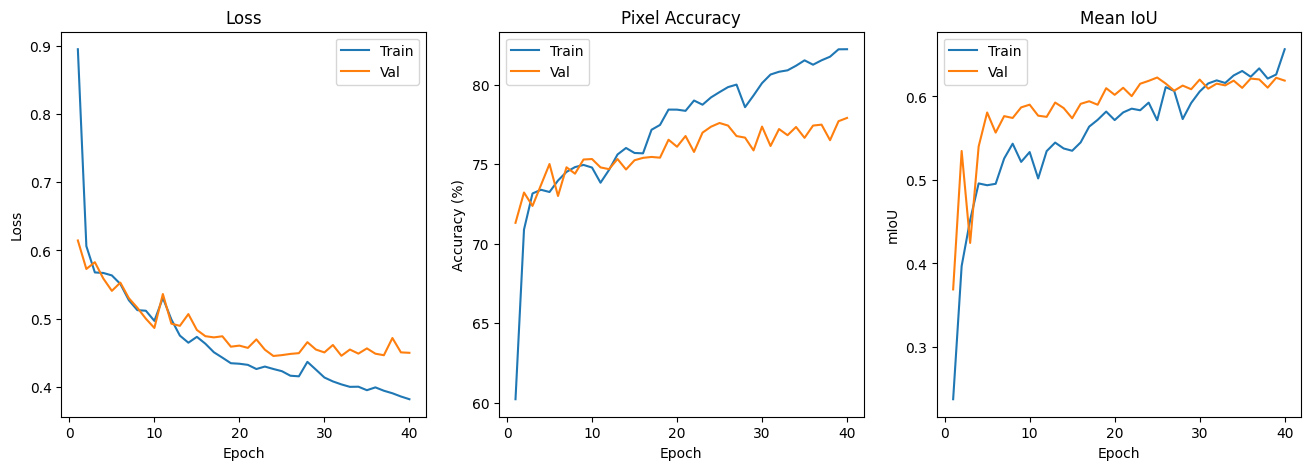

In [58]:
epochs = range(1, num_epochs+1)
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.plot(epochs, train_losses, label="Train")
plt.plot(epochs, val_losses, label="Val")
plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,3,2)
plt.plot(epochs, [a*100 for a in train_accs], label="Train")
plt.plot(epochs, [a*100 for a in val_accs], label="Val")
plt.title("Pixel Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.legend()

plt.subplot(1,3,3)
plt.plot(epochs, train_ious, label="Train")
plt.plot(epochs, val_ious, label="Val")
plt.title("Mean IoU"); plt.xlabel("Epoch"); plt.ylabel("mIoU"); plt.legend()

plt.show()


Calling the trained model

In [ ]:
# from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor

# # Path where you saved earlier
# load_dir = "/content/drive/MyDrive/segformer_lulc"

# # Load trained model + processor
# model = SegformerForSemanticSegmentation.from_pretrained(load_dir)
# processor = SegformerFeatureExtractor.from_pretrained(load_dir)

# print("✅ Trained model and processor loaded successfully!")


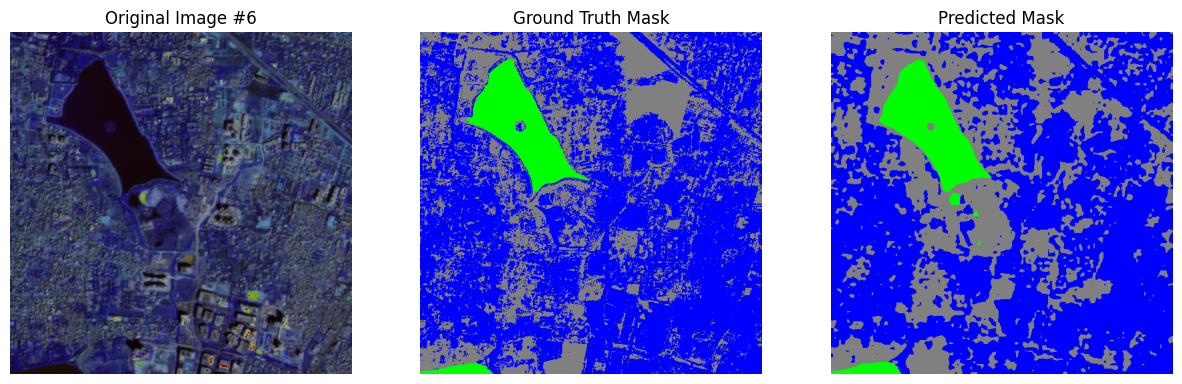

In [62]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch

# Color map for 4 classes
COLOR_MAP = {
    0: (255, 0, 0),     # Urban -> Red
    1: (0, 0, 255),     # Water -> Blue
    2: (0, 255, 0),     # Vegetation -> Green
    3: (128, 128, 128)  # Others -> Gray
}

def decode_color(mask_np):
    """Map class indices to RGB colors for visualization"""
    h, w = mask_np.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls, color in COLOR_MAP.items():
        rgb[mask_np == cls] = color
    return rgb

# -------------------------------
# Inference for a specific index
# -------------------------------
model.eval()
idx = 6   # <-- choose any index here

# Make sure dataset returns correct pair
img, true_mask = val_dataset[idx]   # img: [3,512,512], true_mask: [512,512]
img_batch = img.unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(pixel_values=img_batch)
    pred_mask = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()  # Changed outputs.logits to outputs

# Convert tensors back for visualization
true_mask = true_mask.cpu().numpy()
img_vis = img.cpu().numpy()

# Undo normalization for display
mean = np.array([0.485, 0.456, 0.406]).reshape(3,1,1)
std  = np.array([0.229, 0.224, 0.225]).reshape(3,1,1)
img_vis = (img_vis * std + mean).clip(0,1)
img_vis = np.transpose(img_vis, (1,2,0))  # CHW -> HWC

# -------------------------------
# Show results
# -------------------------------
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(img_vis); plt.title(f"Original Image #{idx}"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(decode_color(true_mask)); plt.title("Ground Truth Mask"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(decode_color(pred_mask)); plt.title("Predicted Mask"); plt.axis("off")
plt.show()

In [ ]:
save_dir = "/content/drive/MyDrive/CustomB2_segformer_lulc"

import os
import torch
os.makedirs(save_dir, exist_ok=True)

# Save trained model state dictionary
torch.save(model.state_dict(), os.path.join(save_dir, 'model_state_dict.pth'))

# The custom model doesn't have a save_pretrained method for the processor.
# If you were using the Hugging Face SegformerForSemanticSegmentation, you would save the processor like this:
# processor.save_pretrained(save_dir)

print(f"✅ Model state dictionary saved to {os.path.join(save_dir, 'model_state_dict.pth')}")

✅ Model state dictionary saved to /content/drive/MyDrive/CustomB2_segformer_lulc/model_state_dict.pth
